## Check pCVP2-BRI1-mCitrine specificity in scRNA-seq

Here we perform analysis against the custom reference. The results are exported and inlcuded in the SI table. 

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(ggplot2)
library(muscat)
library(purrr)
library(limma)
library(scran)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualizati

In [2]:
library(future)
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/tmn23/miniconda3/envs/muscat/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.31.0               scran_1.26.0               
 [3] scuttle_1.8.0               SingleCellExperiment_1.20.0
 [5] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [7] GenomicRanges_1.50.0        GenomeInfoDb_1.34.8        
 [9]

In [4]:
rc.integrated <- readRDS("../../CheWei/scRNA-seq/Integrated_Objects/rc.integrated_8S_CVP_BRI1_seu3_annotated_20230316.rds")

In [5]:
rc.integrated

An object of class Seurat 
71788 features across 55427 samples within 3 assays 
Active assay: SCT (25288 features, 0 variable features)
 2 other assays present: RNA, integrated
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

In [6]:
rc.integrated <- subset(rc.integrated, 
                        subset = orig.ident %in% c("sc_130",
                                              "sc_131",
                                              "sc_132",
                                              "sc_134",
                                              "sc_135",
                                              "sc_136"))

In [7]:
table(rc.integrated$orig.ident, rc.integrated$geno)

        
           WT bri1_T pCVP2_BRI1_Citrine_bri1_T
  sc_130 6589      0                         0
  sc_131    0   7615                         0
  sc_132    0      0                      6550
  sc_134 7745      0                         0
  sc_135    0   5038                         0
  sc_136    0      0                      6089

In [8]:
feature_names <- read_tsv("../data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()

Rows: 32833 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): AGI, Name, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
rc.integrated$geno <- factor(rc.integrated$geno, levels=c("WT", "bri1_T", "pCVP2_BRI1_Citrine_bri1_T"))

## Cell and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`

In [10]:
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
rc.integrated$cell_type <- factor(rc.integrated$cell_type, levels = order[sort(match(unique(rc.integrated$cell_type),order))])
color <- palette[sort(match(unique(rc.integrated$cell_type),order))]

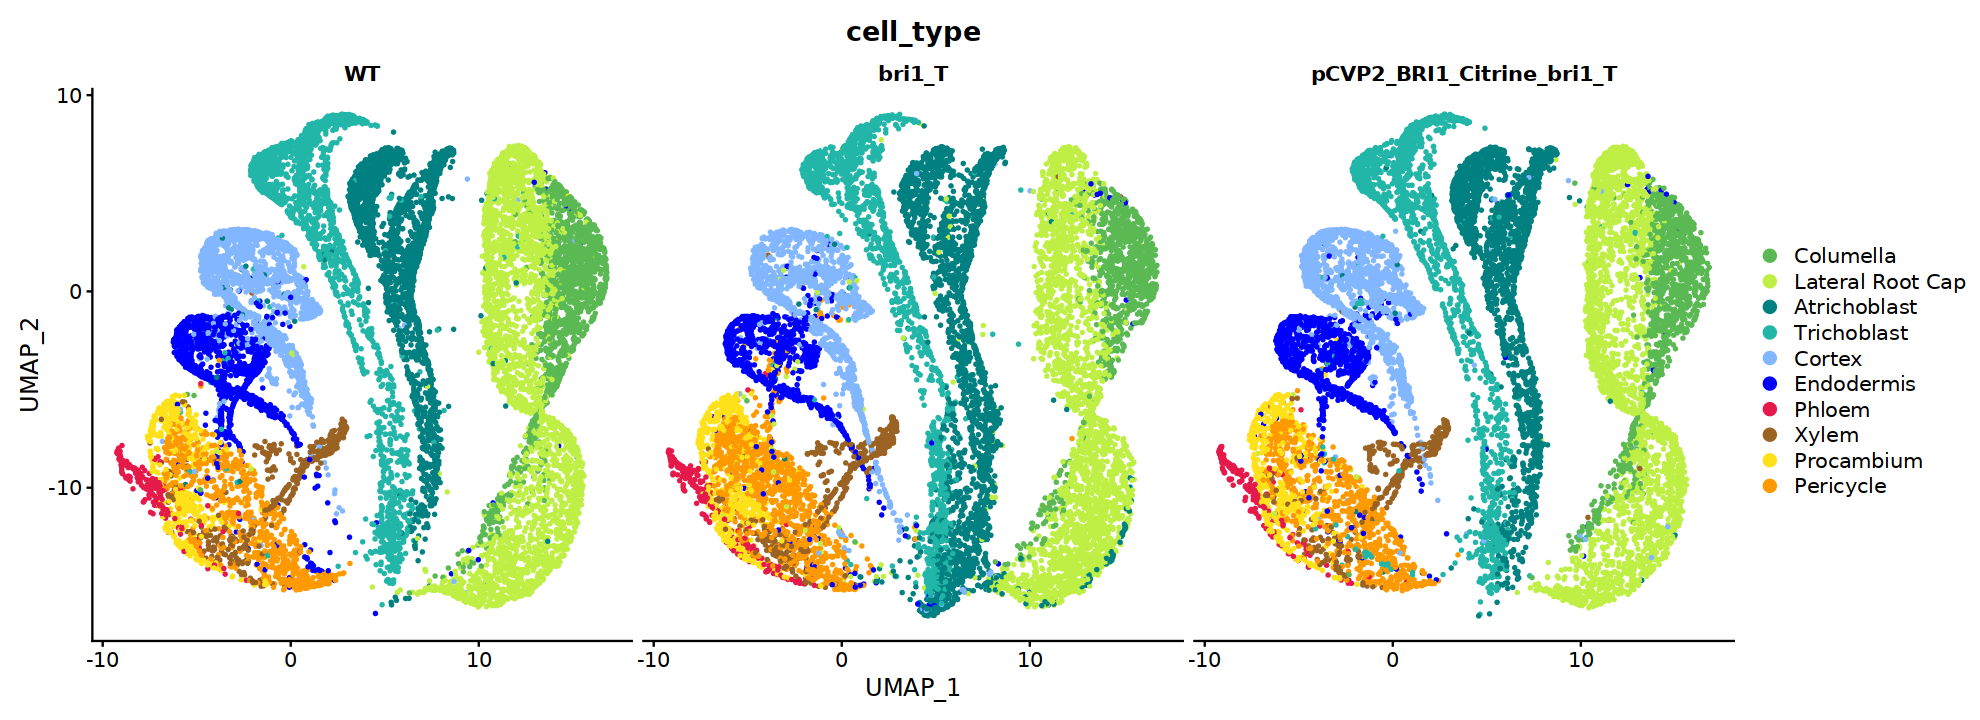

In [11]:
options(repr.plot.width=16.5, repr.plot.height=6)
(Celltype_umap <- DimPlot(rc.integrated, 
                      reduction = "umap", 
                      group.by = "cell_type", 
                      cols = color, split.by = 'geno', 
                      ncol=3, 
                      pt.size = 0.5))

ggsave("../output/CVP/Cell_type_umap_square_all_samples.pdf", width=16.5, height=6)

Warning message in FeaturePlot(rc.integrated, features = "BRI1-mCitrine", split.by = "geno", :
“All cells have the same value (0) of BRI1-mCitrine.”


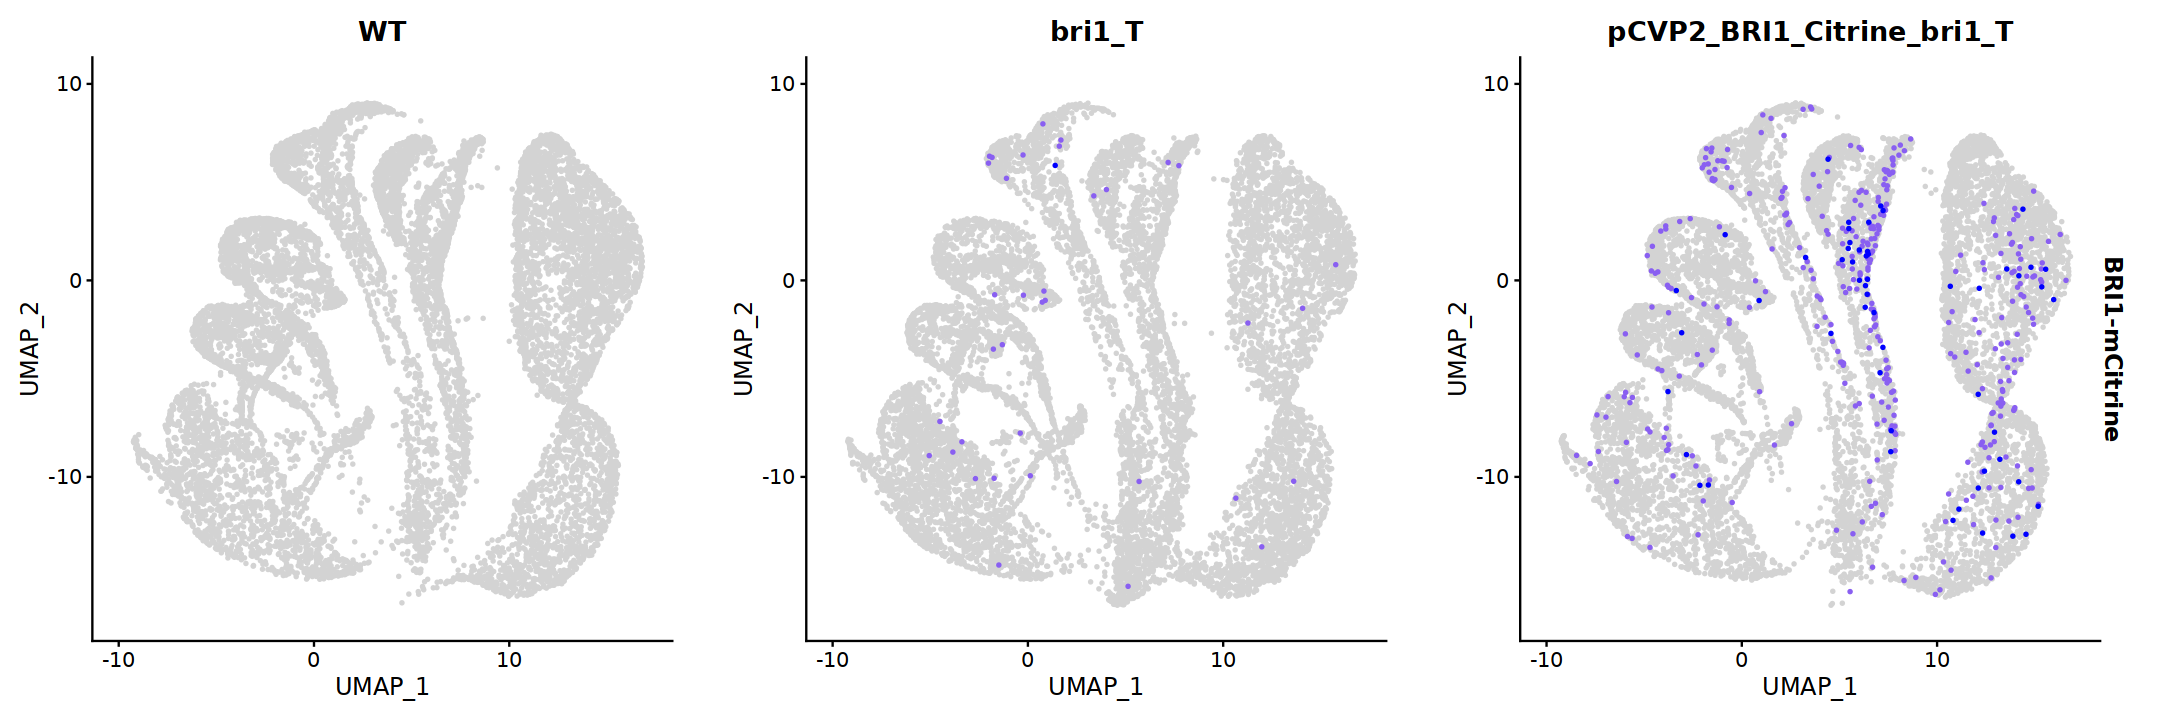

In [12]:
options(repr.plot.width = 18, repr.plot.height = 6)

DefaultAssay(rc.integrated) <- "SCT"
# expression of the transgene
FeaturePlot(rc.integrated, features="BRI1-mCitrine", split.by = "geno", order=T, max.cutoff = "q90", pt.size = 0.5)

ggsave("../output/CVP/BRI1-mCitrine_expression_all_samples.pdf", width=18.3, height=6)

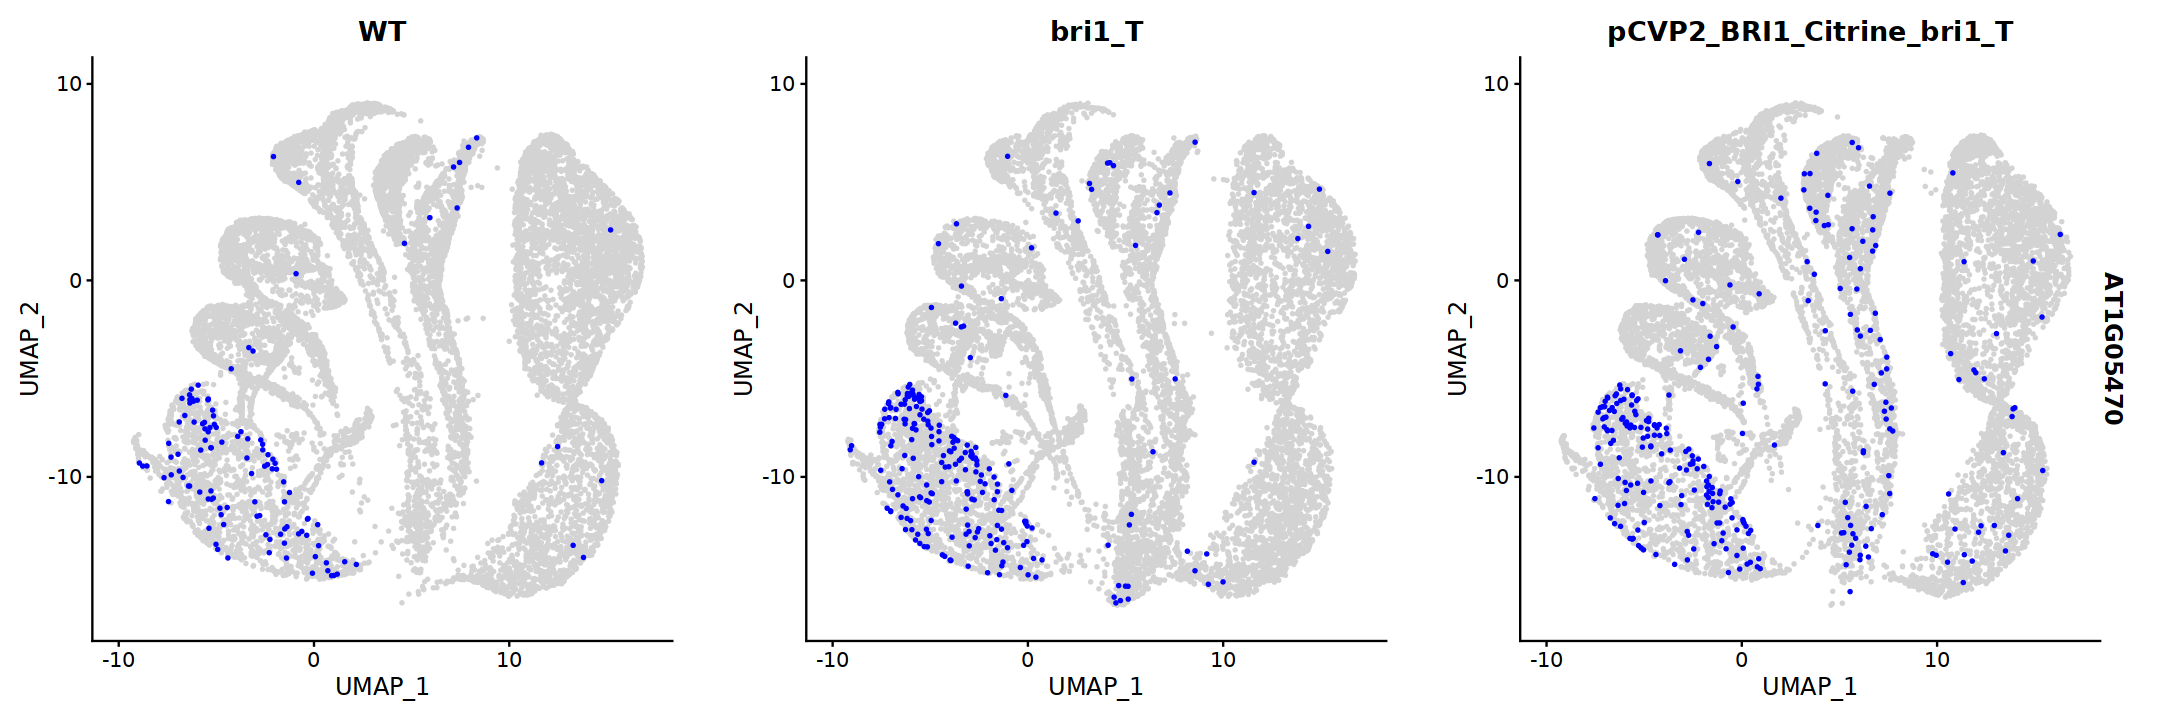

In [13]:
# expression of CVP2
options(repr.plot.width = 18, repr.plot.height = 6)

DefaultAssay(rc.integrated) <- "SCT"
# expression of the transgene
FeaturePlot(rc.integrated, features="AT1G05470", split.by = "geno", order=T, max.cutoff = "q90", pt.size = 0.5)

ggsave("../output/CVP/CVP2_AT1G05470_expression_all_samples.pdf", width=18.3, height=6)

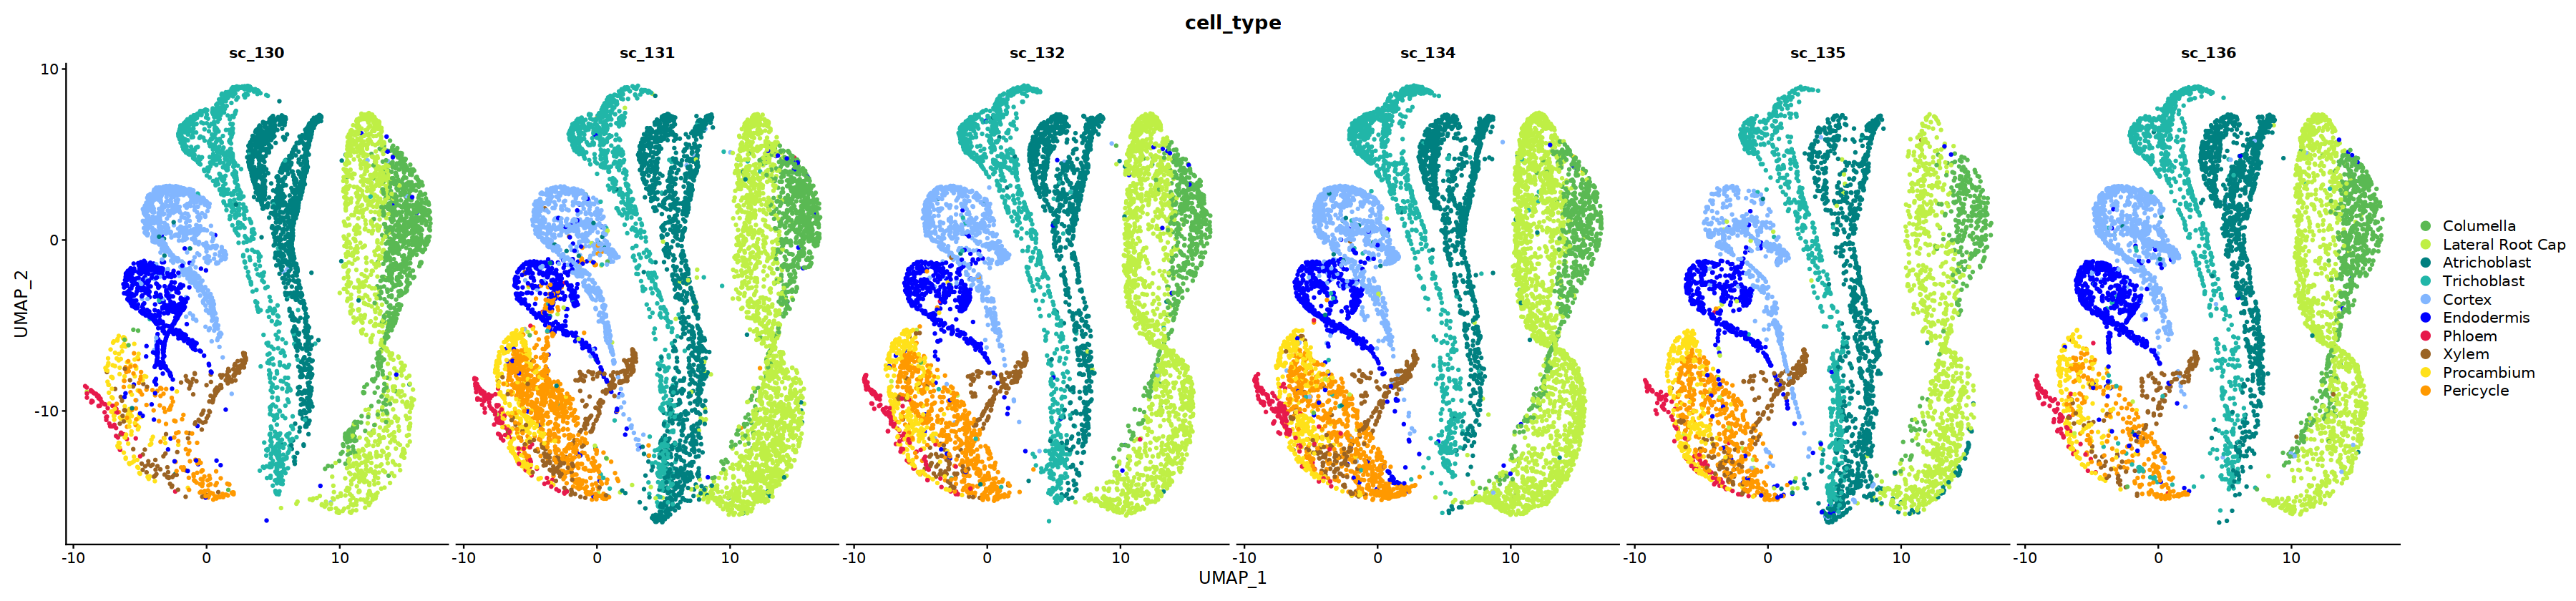

In [14]:
options(repr.plot.width=30, repr.plot.height=7)

DimPlot(rc.integrated, reduction = "umap", group.by = "cell_type", cols = color, split.by = 'orig.ident', pt.size = 0.75, ncol=8)

Warning message in FeaturePlot(rc.integrated, features = "BRI1-mCitrine", split.by = "orig.ident", :
“All cells have the same value (0) of BRI1-mCitrine.”
Warning message in FeaturePlot(rc.integrated, features = "BRI1-mCitrine", split.by = "orig.ident", :
“All cells have the same value (0) of BRI1-mCitrine.”


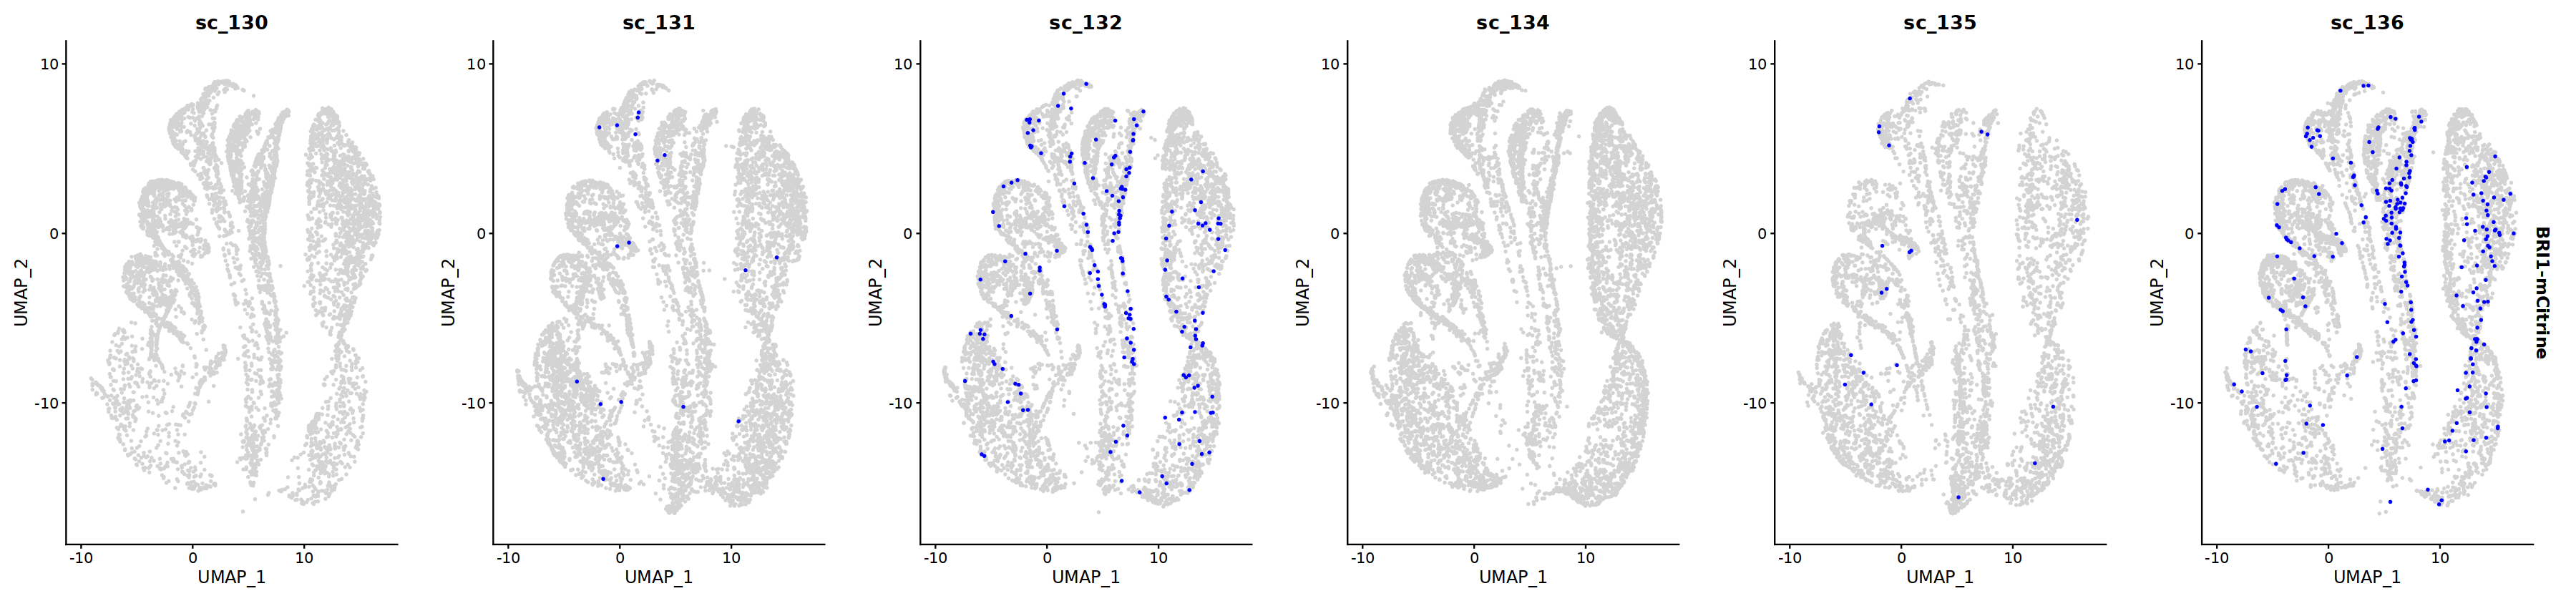

In [15]:
DefaultAssay(rc.integrated) <- "SCT"
# expression of the transgene
FeaturePlot(rc.integrated, features="BRI1-mCitrine", split.by = "orig.ident", order=T, max.cutoff = "q80", pt.size = 0.5)

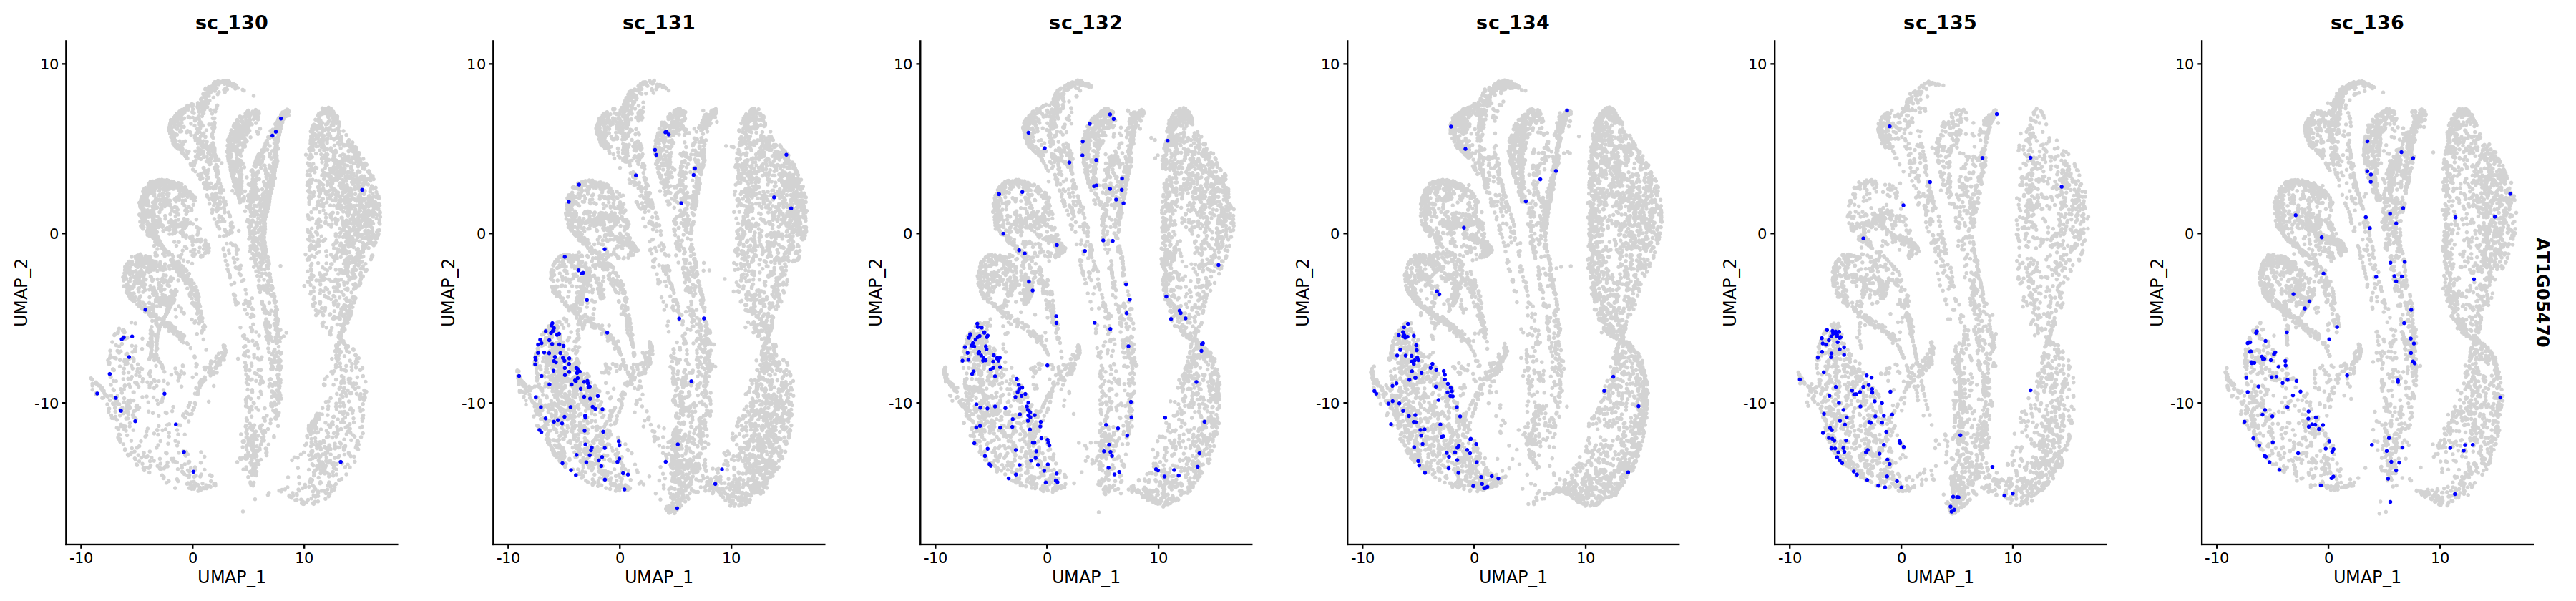

In [16]:
DefaultAssay(rc.integrated) <- "SCT"
# expression of the transgene
FeaturePlot(rc.integrated, features="AT1G05470", split.by = "orig.ident", order=T, max.cutoff = "q80", pt.size = 0.5)

In [17]:
table(rc.integrated$orig.ident, rc.integrated$cell_type)

        
         Columella Lateral Root Cap Atrichoblast Trichoblast Cortex Endodermis
  sc_130       895             1058         1445        1000    972        725
  sc_131       672             1800         1441         900    777        490
  sc_132       474             1597         1089         916    720        544
  sc_134       582             2101         1171        1041    906        573
  sc_135       294              991         1055         707    544        480
  sc_136       649             1240         1176         871    878        617
        
         Phloem Xylem Procambium Pericycle
  sc_130     52   172        127       143
  sc_131    130   273        320       812
  sc_132    138   230        288       554
  sc_134    123   267        348       633
  sc_135     88   191        260       428
  sc_136     78   147        186       247

In [18]:
table(rc.integrated$orig.ident, rc.integrated$time_zone)

        
         Distal Columella Distal Lateral Root Cap Elongation Maturation
  sc_130              834                     699       2433       1206
  sc_131              626                     566       1873       1430
  sc_132              442                     678       1950       1511
  sc_134              535                     971       2472       1673
  sc_135              268                     201       1110        930
  sc_136              610                     581       2009       1302
        
         Meristem Proximal Columella Proximal Lateral Root Cap
  sc_130      998                 60                       359
  sc_131     1887                 36                      1197
  sc_132     1023                 31                       915
  sc_134      921                 44                      1129
  sc_135     1730                 26                       773
  sc_136      891                 37                       659

## Convert to sce

In [19]:
#  construct sce manually
my_metadata <- data.frame(sample_id = rc.integrated$orig.ident,
                              group_id = rc.integrated$geno,
                              cluster_id = rc.integrated$cell_type, 
                             date=rc.integrated$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = rc.integrated@assays$RNA@counts),
	                            colData = my_metadata)

In [20]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 28980 39626 
metadata(1): experiment_info
assays(1): counts
rownames(28980): AT1G01010 AT1G01020 ... AT5G39430 AT5G54075
rowData names(0):
colnames(39626): AAACCCACAACAGCCC_6 AAACCCACAGAGTAAT_6 ...
  TTTGTTGCATCGATAC_11 TTTGTTGTCAAGAGGC_11
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## pre-filtering

In [21]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 26993 39626

In [22]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Columella"        "Lateral Root Cap" "Atrichoblast"     "Trichoblast"     
 [5] "Cortex"           "Endodermis"       "Phloem"           "Xylem"           
 [9] "Procambium"       "Pericycle"

In [23]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

AT1G01010 AT1G01020 AT1G03987 AT1G01030 AT1G01040 AT1G01050
sc_130 68        97        1         21        19        1846     
sc_131 46        92        0         10        17        1092     
sc_132 32        52        0         10        10         901     
sc_134 46        73        0         18        14        1210     
sc_135 14        57        0         11        10         623     
sc_136 55        81        0         19        16        1440

In [24]:
# experiment info for contrasts, add dates from csv

ei <- metadata(sce)$experiment_info

ei

ei$rep <- c(1, 1, 1, 2, 2, 2)
ei
#sample_date <- select(bscs, sample_id=sample, date=rep)

#ei <- left_join(ei, sample_date)

#ei

sample_id group_id                  n_cells
1 sc_130    WT                        6589   
2 sc_131    bri1_T                    7615   
3 sc_132    pCVP2_BRI1_Citrine_bri1_T 6550   
4 sc_134    WT                        7745   
5 sc_135    bri1_T                    5038   
6 sc_136    pCVP2_BRI1_Citrine_bri1_T 6089

sample_id group_id                  n_cells rep
1 sc_130    WT                        6589    1  
2 sc_131    bri1_T                    7615    1  
3 sc_132    pCVP2_BRI1_Citrine_bri1_T 6550    1  
4 sc_134    WT                        7745    2  
5 sc_135    bri1_T                    5038    2  
6 sc_136    pCVP2_BRI1_Citrine_bri1_T 6089    2

In [25]:
mm <- model.matrix(~ 0 + ei$group_id + ei$rep)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "rep"))

mm

WT bri1_T pCVP2_BRI1_Citrine_bri1_T rep
sc_130 1  0      0                         1  
sc_131 0  1      0                         1  
sc_132 0  0      1                         1  
sc_134 1  0      0                         2  
sc_135 0  1      0                         2  
sc_136 0  0      1                         2

In [26]:
contrast <- makeContrasts("pCVP2_BRI1_Citrine_bri1_T-bri1_T", 
                            "pCVP2_BRI1_Citrine_bri1_T-WT", levels = mm)

contrast

Contrasts
Levels                      pCVP2_BRI1_Citrine_bri1_T-bri1_T
  WT                         0                              
  bri1_T                    -1                              
  pCVP2_BRI1_Citrine_bri1_T  1                              
  rep                        0                              
                           Contrasts
Levels                      pCVP2_BRI1_Citrine_bri1_T-WT
  WT                        -1                          
  bri1_T                     0                          
  pCVP2_BRI1_Citrine_bri1_T  1                          
  rep                        0

In [27]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

  |======================================================================| 100%



### DEG results

In [28]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene      cluster_id sc_130.cpm sc_134.cpm sc_131.cpm sc_135.cpm
1      AT1G01010 Columella    9.860      9.66       8.300      4.610   
2      AT1G01010 Columella    9.860      9.66       8.300      4.610   
3      AT1G01020 Columella   14.100     15.30      16.600     18.800   
4      AT1G01020 Columella   14.100     15.30      16.600     18.800   
5      AT1G03987 Columella    0.145      0.00       0.000      0.000   
6      AT1G03987 Columella    0.145      0.00       0.000      0.000   
7      AT1G01030 Columella    3.050      3.78       1.800      3.620   
8      AT1G01030 Columella    3.050      3.78       1.800      3.620   
9      AT1G01040 Columella    2.760      2.94       3.070      3.290   
10     AT1G01040 Columella    2.760      2.94       3.070      3.290   
11     AT1G01050 Columella  268.000    254.00     197.000    205.000   
12     AT1G01050 Columella  268.000    254.00     197.000    205.000   
13     AT1G01060 Columella    0.435      0.84       0.722      0.988   
14     AT1G01060 Columella    0.435      0.84       0.722      0.988   
15     AT1G01070 Columella    0.145      0.21       1.440      0.329   
16     AT1G01070 Columella    0.145      0.21       1.440      0.329   
17     AT1G01080 Columella    0.435      0.42       0.722      0.658   
18     AT1G01080 Columella    0.435      0.42       0.722      0.658   
19     AT1G01090 Columella   38.000     39.10      41.700     41.500   
20     AT1G01090 Columella   38.000     39.10      41.700     41.500   
21     AT1G01100 Columella  267.000    297.00     407.000    492.000   
22     AT1G01100 Columella  267.000    297.00     407.000    492.000   
23     AT1G01110 Columella    2.180      2.52       2.160      0.658   
24     AT1G01110 Columella    2.180      2.52       2.160      0.658   
25     AT1G01120 Columella    2.030      3.15       1.980      0.658   
26     AT1G01120 Columella    2.030      3.15       1.980      0.658   
27     AT1G01130 Columella    0.435      1.26       1.080      0.658   
28     AT1G01130 Columella    0.435      1.26       1.080      0.658   
29     AT1G01140 Columella   24.200     16.20      14.100      9.220   
30     AT1G01140 Columella   24.200     16.20      14.100      9.220   
⋮      ⋮         ⋮          ⋮          ⋮          ⋮          ⋮         
465033 AT1G49205 Pericycle  0          0.2940     0          0.0000    
465034 AT1G49205 Pericycle  0          0.2940     0          0.0000    
465035 AT2G07975 Pericycle  0          0.0588     0          0.0000    
465036 AT2G07975 Pericycle  0          0.0588     0          0.0000    
465037 AT3G53070 Pericycle  0          0.0588     0          0.0000    
465038 AT3G53070 Pericycle  0          0.0588     0          0.0000    
465039 AT3G08325 Pericycle  0          0.0588     0          0.0000    
465040 AT3G08325 Pericycle  0          0.0588     0          0.0000    
465041 AT5G17345 Pericycle  0          0.1180     0          0.0000    
465042 AT5G17345 Pericycle  0          0.1180     0          0.0000    
465043 AT1G43722 Pericycle  0          0.0000     0          0.0797    
465044 AT1G43722 Pericycle  0          0.0000     0          0.0797    
465045 AT1G60025 Pericycle  0          0.0000     0          0.0797    
465046 AT1G60025 Pericycle  0          0.0000     0          0.0797    
465047 AT3G04440 Pericycle  0          0.0000     0          0.0797    
465048 AT3G04440 Pericycle  0          0.0000     0          0.0797    
465049 AT3G25014 Pericycle  0          0.0000     0          0.0797    
465050 AT3G25014 Pericycle  0          0.0000     0          0.0797    
465051 AT4G03765 Pericycle  0          0.0000     0          0.0797    
465052 AT4G03765 Pericycle  0          0.0000     0          0.0797    
465053 AT4G10190 Pericycle  0          0.0000     0          0.0797    
465054 AT4G10190 Pericycle  0          0.0000     0          0.0797    
465055 AT2G19010 Pericycle  0          0.0000     0          0.0000    
465056 AT2G19010 Pericycle  0          0.0000  

In [29]:
## all genes as background

all_bg <- res_to_write_frq

In [30]:
all_bg %>% filter(gene=="BRI1-mCitrine") %>%
arrange(desc(sc_136.cpm))

gene          cluster_id       sc_130.cpm sc_134.cpm sc_131.cpm sc_135.cpm
1  BRI1-mCitrine Atrichoblast     0          0          0.1760     0.0766    
2  BRI1-mCitrine Atrichoblast     0          0          0.1760     0.0766    
3  BRI1-mCitrine Columella        0          0          0.3610     0.3290    
4  BRI1-mCitrine Columella        0          0          0.3610     0.3290    
5  BRI1-mCitrine Lateral Root Cap 0          0          0.0515     0.1630    
6  BRI1-mCitrine Lateral Root Cap 0          0          0.0515     0.1630    
7  BRI1-mCitrine Trichoblast      0          0          0.4060     0.3200    
8  BRI1-mCitrine Trichoblast      0          0          0.4060     0.3200    
9  BRI1-mCitrine Phloem           0          0          0.0000     0.0000    
10 BRI1-mCitrine Phloem           0          0          0.0000     0.0000    
11 BRI1-mCitrine Xylem            0          0          0.3750     0.2570    
12 BRI1-mCitrine Xylem            0          0          0.3750     0.2570    
13 BRI1-mCitrine Procambium       0          0          0.0000     0.0000    
14 BRI1-mCitrine Procambium       0          0          0.0000     0.0000    
15 BRI1-mCitrine Pericycle        0          0          0.4970     0.4780    
16 BRI1-mCitrine Pericycle        0          0          0.4970     0.4780    
17 BRI1-mCitrine Cortex           0          0          0.2090     0.1940    
18 BRI1-mCitrine Cortex           0          0          0.2090     0.1940    
19 BRI1-mCitrine Endodermis       0          0          0.3760     0.3890    
20 BRI1-mCitrine Endodermis       0          0          0.3760     0.3890    
   sc_132.cpm sc_136.cpm sc_130.frq sc_134.frq ⋯ WT.frq bri1_T.frq
1  5.090      8.22       0          0          ⋯ 0      0.00280   
2  5.090      8.22       0          0          ⋯ 0      0.00280   
3  5.810      7.60       0          0          ⋯ 0      0.00311   
4  5.810      7.60       0          0          ⋯ 0      0.00311   
5  3.080      3.94       0          0          ⋯ 0      0.00107   
6  3.080      3.94       0          0          ⋯ 0      0.00107   
7  3.200      2.59       0          0          ⋯ 0      0.00871   
8  3.200      2.59       0          0          ⋯ 0      0.00871   
9  0.000      2.56       0          0          ⋯ 0      0.00000   
10 0.000      2.56       0          0          ⋯ 0      0.00000   
11 0.794      2.18       0          0          ⋯ 0      0.00647   
12 0.794      2.18       0          0          ⋯ 0      0.00647   
13 2.790      2.12       0          0          ⋯ 0      0.00000   
14 2.790      2.12       0          0          ⋯ 0      0.00000   
15 2.660      2.03       0          0          ⋯ 0      0.01130   
16 2.660      2.03       0          0          ⋯ 0      0.01130   
17 1.420      1.68       0          0          ⋯ 0      0.00454   
18 1.420      1.68       0          0          ⋯ 0      0.00454   
19 0.508      1.36       0          0          ⋯ 0      0.00825   
20 0.508      1.36       0          0          ⋯ 0      0.00825   
   pCVP2_BRI1_Citrine_bri1_T.frq logFC logCPM  F      p_val    p_adj.loc
1  0.0870                         5.60  1.1000 133.00 1.68e-07 2.16e-05 
2  0.0870                        10.20  1.1000 160.00 6.42e-08 7.86e-04 
3  0.0490                         4.12  1.4000  37.30 1.01e-09 1.34e-07 
4  0.0490                         7.99  1.4000  66.20 4.22e-16 1.09e-12 
5  0.0271                         5.03  0.3110  60.80 4.33e-05 3.70e-03 
6  0.0271                         8.67  0.3110  72.80 2.22e-05 1.37e-01 
7  0.0862                         2.98  0.2080  50.70 2.01e-05 2.52e-03 
8  0.0862                         9.36  0.2080 157.00 7.98e-08 6.49e-04 
9  0.0139                         4.12  0.6840   1.54 2.15e-01 9.13e-01 
10 0.0139                         4.61  0.6840   1.88 1.71e-01 1.00e+00 
11 0.0345                         1.99 -0.0746   2.98 1.03e-01 4.84e-01 
12 0.0345                         5.95 -0.0746  11.40 3.87e-03 2.38e-01 
13 0.0443

In [31]:
length(unique(all_bg$gene))

[1] 26993

In [32]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 10281

In [33]:
# filter gene freqs to avoid calling lowly detected genes
sig_DE_fil <- filter(sig_DE, WT.frq >=0.05 | bri1_T.frq >=0.05 | pCVP2_BRI1_Citrine_bri1_T.frq >=0.05)

In [34]:
length(unique(sig_DE_fil$gene))

[1] 8694

In [35]:
# load TFs
TF_list <- read_csv("../data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 

Rows: 2485 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): gene, TF_Name, Description

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [36]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining with `by = join_by(gene)`


In [37]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene      cluster_id sc_130.cpm sc_134.cpm sc_131.cpm sc_135.cpm
1     AT1G01240 Columella    31.90      25.20     15.30      14.20    
2     AT1G01580 Columella    41.20      32.80     15.20      18.10    
3     AT1G01620 Columella   623.00     348.00    256.00     189.00    
4     AT1G01640 Columella    10.70      10.50      3.07       6.58    
5     AT1G01725 Columella    14.90      16.20      4.87       4.28    
6     AT1G02430 Columella     8.99       7.98      5.23       3.29    
7     AT1G02610 Columella    23.10      23.30     13.50      10.90    
8     AT1G02860 Columella    70.90      71.80     51.40      38.50    
9     AT1G02870 Columella     6.24      17.00     18.60      22.70    
10    AT1G03030 Columella    19.70      19.70     13.20      14.80    
11    AT1G03200 Columella    14.20      13.40      4.69       6.91    
12    AT1G03850 Columella    58.40      53.40     42.00      38.50    
13    AT1G03870 Columella   221.00     105.00     95.20      53.00    
14    AT1G04100 Columella    22.20      24.40     36.10      35.60    
15    AT1G04180 Columella    20.30      20.20      6.13       9.22    
16    AT1G04280 Columella    14.10      13.40      5.23       4.61    
17    AT1G04870 Columella     2.18       2.94      8.30      12.20    
18    AT1G05680 Columella  1080.00    1030.00    730.00     738.00    
19    AT1G05840 Columella     7.54       9.24      3.25       5.93    
20    AT1G06090 Columella    81.10     124.00     88.70      37.50    
21    AT1G06330 Columella    54.40      46.40     20.20      21.10    
22    AT1G07030 Columella    71.80      58.00     44.70      43.80    
23    AT1G07070 Columella     5.22       9.03     17.00      21.70    
24    AT1G07160 Columella   209.00     149.00    113.00     116.00    
25    AT1G07175 Columella   158.00     134.00     81.30     100.00    
26    AT1G07290 Columella    36.40      29.40     11.70      16.80    
27    AT1G07930 Columella    39.60      49.60     69.30      81.60    
28    AT1G08310 Columella     7.25      11.10      9.20       2.96    
29    AT1G08500 Columella    35.70      19.10     11.90       9.22    
30    AT1G08890 Columella    11.70      13.90      5.05       2.63    
⋮     ⋮         ⋮          ⋮          ⋮          ⋮          ⋮         
15280 AT2G17660 Pericycle    0.982      1.4700    17.000     15.700   
15281 AT2G18620 Pericycle    1.720      1.9400    11.100     11.600   
15282 AT2G26910 Pericycle    3.680      2.3500    10.900      8.450   
15283 AT2G33790 Pericycle   12.800     11.3000    59.400     38.700   
15284 AT2G33860 Pericycle    2.210      1.7000     5.710      7.330   
15285 AT2G36640 Pericycle    0.000      0.8820     6.640     10.400   
15286 AT2G37540 Pericycle   28.500     20.9000     3.540      2.710   
15287 AT2G37870 Pericycle    0.982      5.5800    66.300     68.100   
15288 AT2G38530 Pericycle  133.000    198.0000   110.000     84.100   
15289 AT2G39681 Pericycle   10.300      8.8800     4.720      3.750   
15290 AT2G39700 Pericycle   12.500     10.2000     8.690      4.940   
15291 AT2G45050 Pericycle    3.930      2.8200    27.900     17.100   
15292 AT2G46400 Pericycle   28.200     50.7000   107.000    115.000   
15293 AT2G48010 Pericycle    5.400      3.7000     8.260      7.570   
15294 AT4G01650 Pericycle   24.100     39.0000    11.400      9.640   
15295 AT4G04223 Pericycle    1.720      0.1760     4.780      4.220   
15296 AT4G11190 Pericycle   80.000     64.4000   197.000    204.000   
15297 AT4G11211 Pericycle  250.000    269.0000    96.700     84.300   
15298 AT4G12430 Pericycle   14.000     14.6000     5.090      4.620   
15299 AT4G13860 Pericycle    8.100     10.6000     6.710      5.820   
15300 AT4G15920 Pericycle   12.000     13.5000     2.730      1.200   
15301 AT4G16000 Pericycle    0.000      0.0588     3.910      3.670   
15302 AT4G16990 Pericycle   12.000      5.8800     0.124      0.159   
15303 AT4G22214 Pericycle   16.400     12.2000    55.200     32.400   
15304 AT4G23450 Pericycle   11

In [38]:
sig_DE_fil
write.csv(sig_DE_fil, file = "../output/CVP/pCVP2_Citrine_celltype_EdgeR_q0.05_FC1.5_r_v_4_20240429.csv")

gene      cluster_id sc_130.cpm sc_134.cpm sc_131.cpm sc_135.cpm
1     AT1G01240 Columella    31.90      25.20     15.30      14.20    
2     AT1G01580 Columella    41.20      32.80     15.20      18.10    
3     AT1G01620 Columella   623.00     348.00    256.00     189.00    
4     AT1G01640 Columella    10.70      10.50      3.07       6.58    
5     AT1G01725 Columella    14.90      16.20      4.87       4.28    
6     AT1G02430 Columella     8.99       7.98      5.23       3.29    
7     AT1G02610 Columella    23.10      23.30     13.50      10.90    
8     AT1G02860 Columella    70.90      71.80     51.40      38.50    
9     AT1G02870 Columella     6.24      17.00     18.60      22.70    
10    AT1G03030 Columella    19.70      19.70     13.20      14.80    
11    AT1G03200 Columella    14.20      13.40      4.69       6.91    
12    AT1G03850 Columella    58.40      53.40     42.00      38.50    
13    AT1G03870 Columella   221.00     105.00     95.20      53.00    
14    AT1G04100 Columella    22.20      24.40     36.10      35.60    
15    AT1G04180 Columella    20.30      20.20      6.13       9.22    
16    AT1G04280 Columella    14.10      13.40      5.23       4.61    
17    AT1G04870 Columella     2.18       2.94      8.30      12.20    
18    AT1G05680 Columella  1080.00    1030.00    730.00     738.00    
19    AT1G05840 Columella     7.54       9.24      3.25       5.93    
20    AT1G06090 Columella    81.10     124.00     88.70      37.50    
21    AT1G06330 Columella    54.40      46.40     20.20      21.10    
22    AT1G07030 Columella    71.80      58.00     44.70      43.80    
23    AT1G07070 Columella     5.22       9.03     17.00      21.70    
24    AT1G07160 Columella   209.00     149.00    113.00     116.00    
25    AT1G07175 Columella   158.00     134.00     81.30     100.00    
26    AT1G07290 Columella    36.40      29.40     11.70      16.80    
27    AT1G07930 Columella    39.60      49.60     69.30      81.60    
28    AT1G08310 Columella     7.25      11.10      9.20       2.96    
29    AT1G08500 Columella    35.70      19.10     11.90       9.22    
30    AT1G08890 Columella    11.70      13.90      5.05       2.63    
⋮     ⋮         ⋮          ⋮          ⋮          ⋮          ⋮         
15280 AT2G17660 Pericycle    0.982      1.4700    17.000     15.700   
15281 AT2G18620 Pericycle    1.720      1.9400    11.100     11.600   
15282 AT2G26910 Pericycle    3.680      2.3500    10.900      8.450   
15283 AT2G33790 Pericycle   12.800     11.3000    59.400     38.700   
15284 AT2G33860 Pericycle    2.210      1.7000     5.710      7.330   
15285 AT2G36640 Pericycle    0.000      0.8820     6.640     10.400   
15286 AT2G37540 Pericycle   28.500     20.9000     3.540      2.710   
15287 AT2G37870 Pericycle    0.982      5.5800    66.300     68.100   
15288 AT2G38530 Pericycle  133.000    198.0000   110.000     84.100   
15289 AT2G39681 Pericycle   10.300      8.8800     4.720      3.750   
15290 AT2G39700 Pericycle   12.500     10.2000     8.690      4.940   
15291 AT2G45050 Pericycle    3.930      2.8200    27.900     17.100   
15292 AT2G46400 Pericycle   28.200     50.7000   107.000    115.000   
15293 AT2G48010 Pericycle    5.400      3.7000     8.260      7.570   
15294 AT4G01650 Pericycle   24.100     39.0000    11.400      9.640   
15295 AT4G04223 Pericycle    1.720      0.1760     4.780      4.220   
15296 AT4G11190 Pericycle   80.000     64.4000   197.000    204.000   
15297 AT4G11211 Pericycle  250.000    269.0000    96.700     84.300   
15298 AT4G12430 Pericycle   14.000     14.6000     5.090      4.620   
15299 AT4G13860 Pericycle    8.100     10.6000     6.710      5.820   
15300 AT4G15920 Pericycle   12.000     13.5000     2.730      1.200   
15301 AT4G16000 Pericycle    0.000      0.0588     3.910      3.670   
15302 AT4G16990 Pericycle   12.000      5.8800     0.124      0.159   
15303 AT4G22214 Pericycle   16.400     12.2000    55.200     32.400   
15304 AT4G23450 Pericycle   11

In [39]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(contrast, cluster_id, gene, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [40]:
all_bg <- mutate(all_bg, clust_gene=paste(contrast, cluster_id, gene, sep="_"))

In [41]:
all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

In [42]:
all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene

In [43]:
all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

In [44]:
write.csv(all_bg, file = "../output/CVP/all_genes_pCVP2_Citrine_celltype_EdgeR_q0.05_FC1.5_r_v_4_20240429.csv")

# Plotting

In [45]:
rc.integrated$geno <- factor(rc.integrated$geno, 
                             levels=c("WT", "bri1_T", "pCVP2_BRI1_Citrine_bri1_T"))

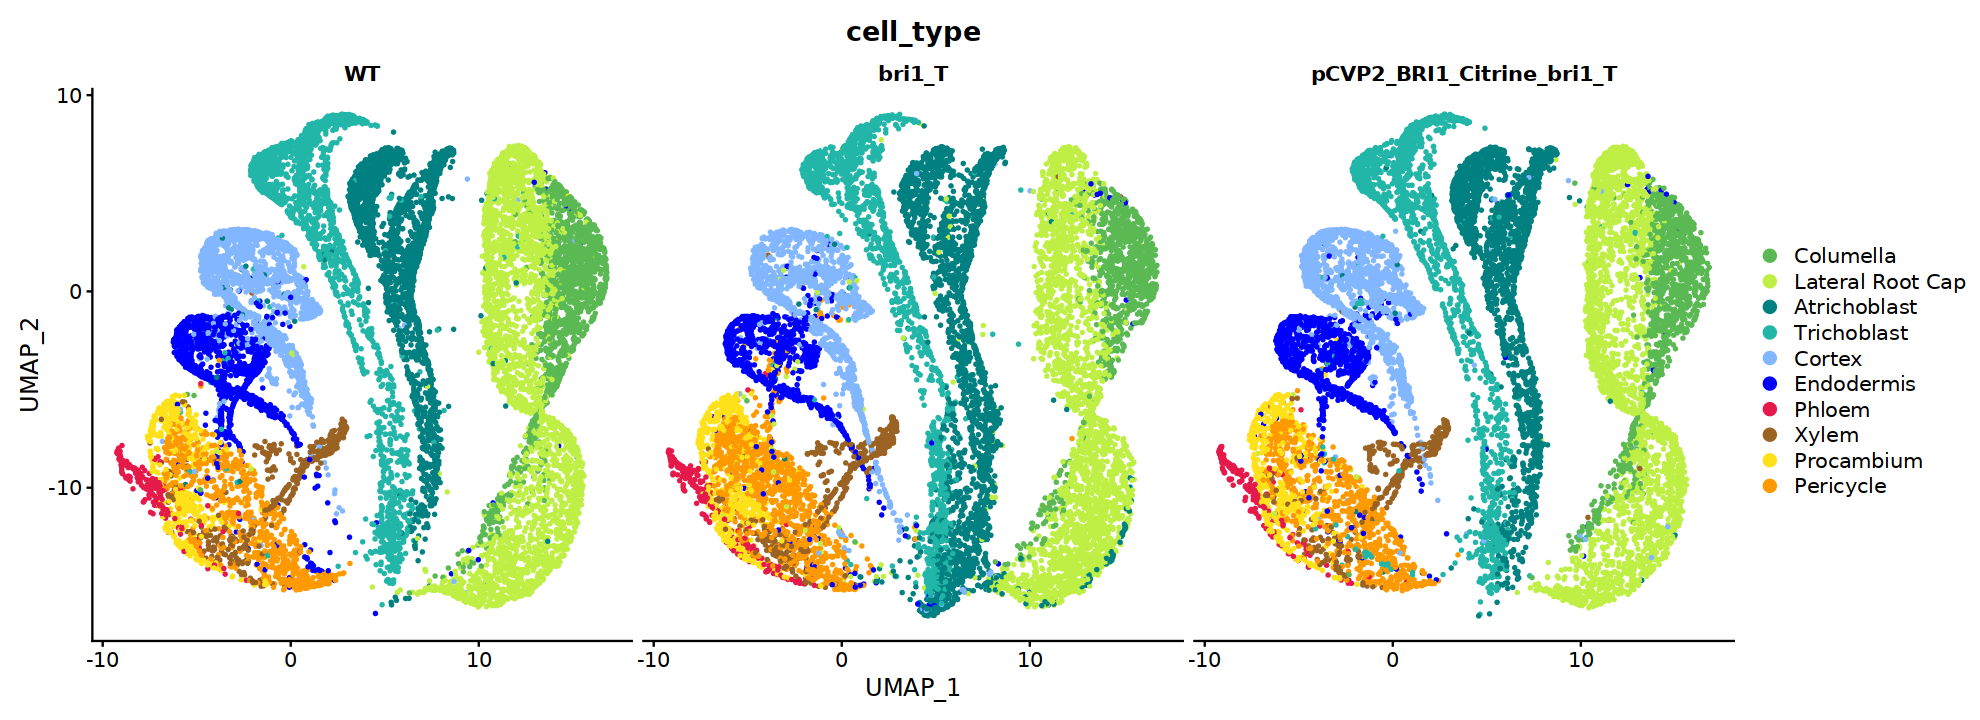

In [46]:
options(repr.plot.width=16.5, repr.plot.height=6)
(Celltype_umap <- DimPlot(rc.integrated, 
                      reduction = "umap", 
                      group.by = "cell_type", 
                      cols = color, split.by = 'geno', 
                      ncol=3, 
                      pt.size = 0.5))

ggsave("../output/CVP/Cell_type_umap_square.pdf", width=16.5, height=6)

Warning message in FeaturePlot(rc.integrated, features = "BRI1-mCitrine", split.by = "geno", :
“All cells have the same value (0) of BRI1-mCitrine.”


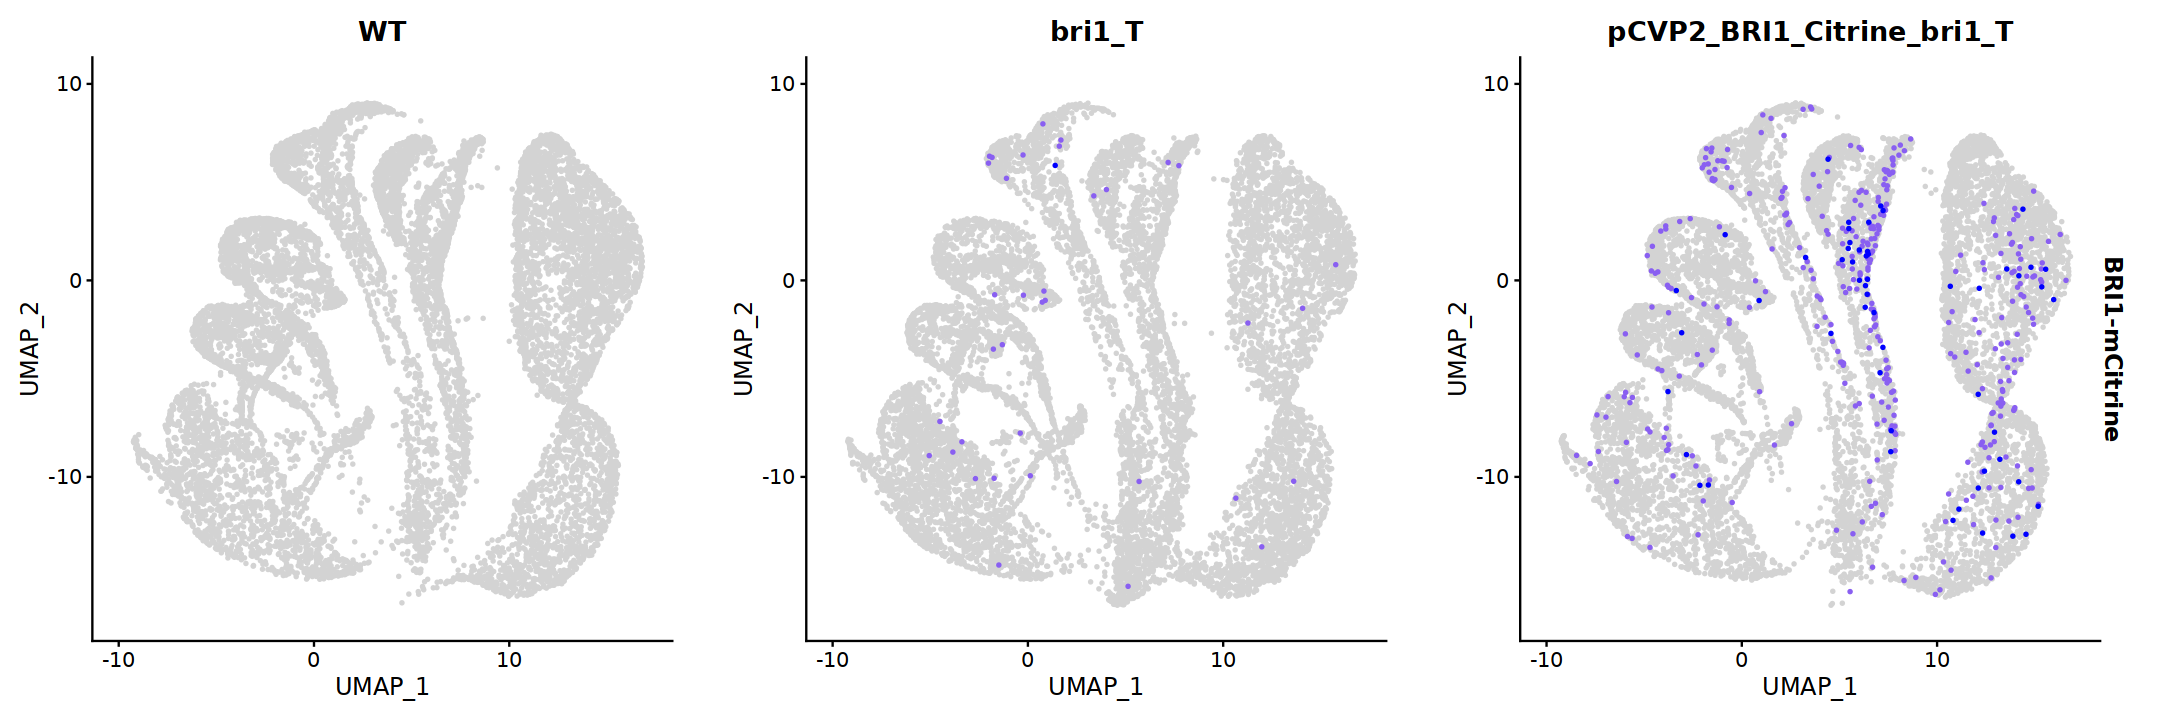

In [47]:
options(repr.plot.width = 18, repr.plot.height = 6)

DefaultAssay(rc.integrated) <- "SCT"
# expression of the transgene
FeaturePlot(rc.integrated, features="BRI1-mCitrine", split.by = "geno", order=T, max.cutoff = "q90", pt.size = 0.5)

ggsave("../output/CVP/BRI1-mCitrine_expression.pdf", width=18.3, height=6)

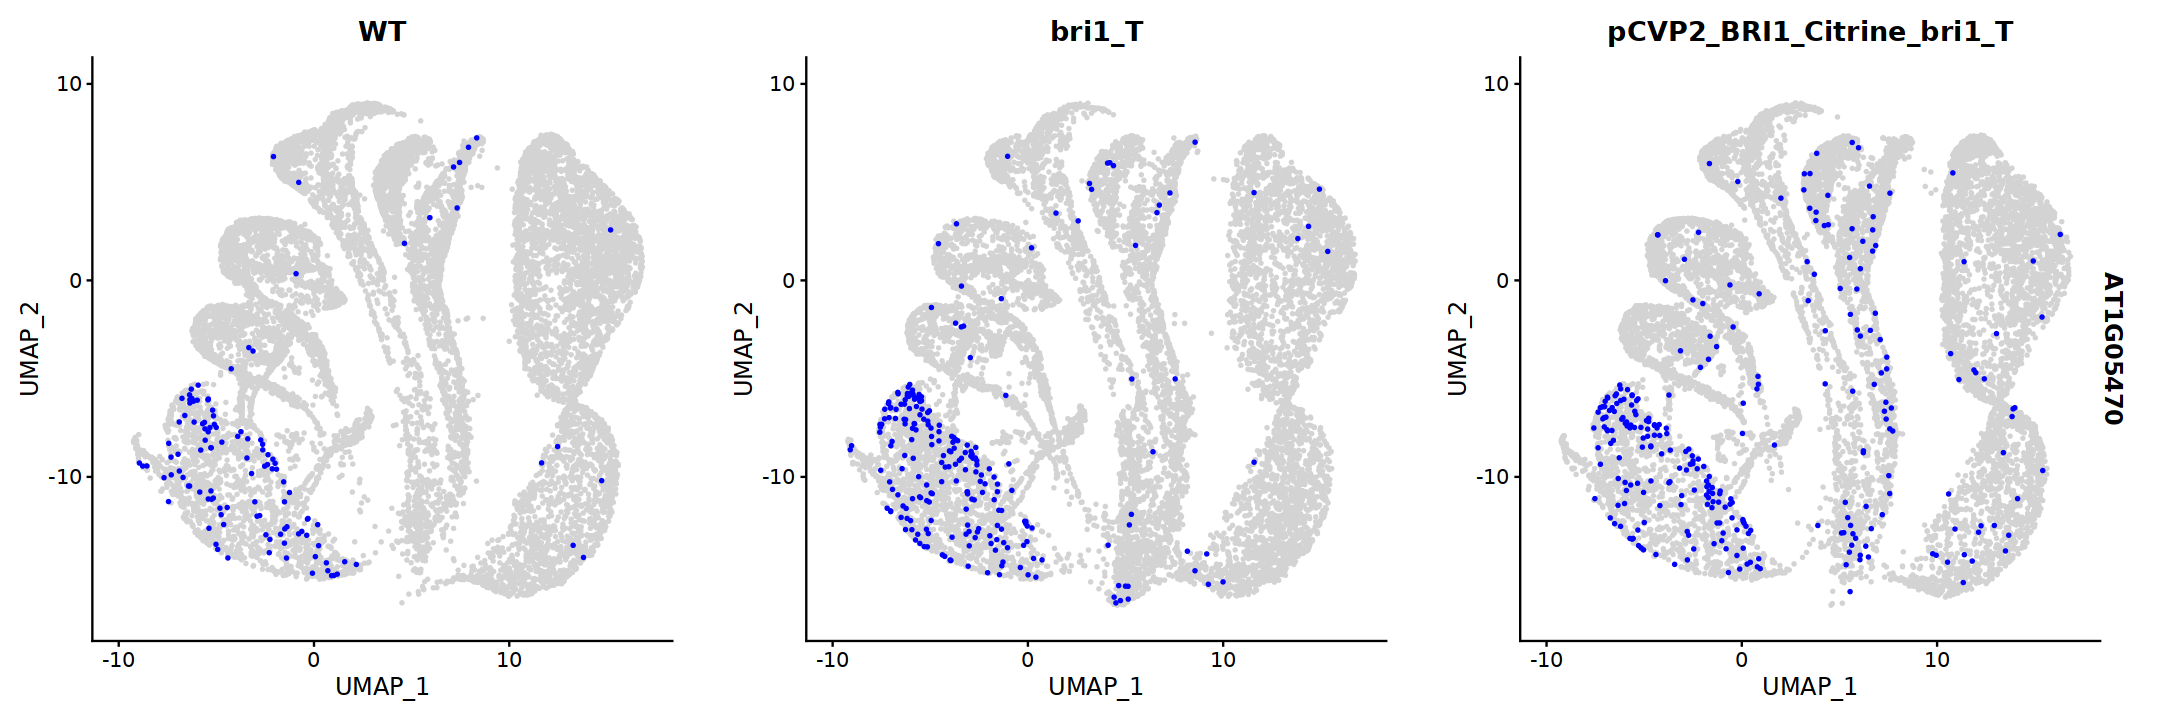

In [48]:
# expression of CVP2
options(repr.plot.width = 18, repr.plot.height = 6)

DefaultAssay(rc.integrated) <- "SCT"
# expression of the transgene
FeaturePlot(rc.integrated, features="AT1G05470", split.by = "geno", order=T, max.cutoff = "q90", pt.size = 0.5)

ggsave("../output/CVP/CVP2_AT1G05470_expression.pdf", width=18.3, height=6)